# SpikeInterface Tutorial - NWB User Days Workshop  - May 2020


In this tutorial, we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison. We will be using the `spikeinterface` from the SpikeInterface github organization. 

`spikeinterface` wraps 5 subpackages: `spikeextractors`, `spikesorters`, `spiketoolkit`, `spikecomparison`, and `spikewidgets`.

For this analysis, we will be using a real dataset recorded from CA1 region in the hippocampus (recording from [CINPLA](https://www.mn.uio.no/ibv/english/research/sections/fyscell/cinpla/)). We will show how to:

- load the data with spikeextractors package
- load a probe file
- preprocess the signals
- run a popular spike sorting algorithm with different parameters
- curate the spike sorting output using 1) quality metrics (automatic) - 2) [Phy](https://github.com/cortex-lab/phy) 
(manual) - 3) consensus-based
- save the results to NWB!


We recommend creating a new `spiketutorial` conda environment using:

`conda env create -f environment.yml`

In addition, for the conda environment, you need to install [Phy](https://github.com/cortex-lab/phy) for the manual curation step.

`pip install phy --pre --upgrade`


Alternatively, you can install the requirements you can use the `requirements.txt` in this directory by running the command:

`pip install -r requirements.txt`

(in this case Phy should be automatically installed)


### Downloading the recording

First, we need to download the recording. Feel free to use your own recordings as well later on. 
From this Zenodo [link](https://doi.org/10.5281/zenodo.3825284), you can download the dataset mentioned above (`open-ephys-dataset.zip`). Move the dataset in the current folder and unzip it.
The recording was performed with the mircodrives with 4 tetrodes each (in total 32 channels).


### Importing the modules

Let's now import the `spikeinterface` modules that we need.

In [1]:
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import matplotlib.pylab as plt
import numpy as np
%matplotlib notebook

21:41:44 [I] klustakwik KlustaKwik2 version 0.2.6


## Loading recording and probe information

In [2]:
recording_folder = 'open-ephys-dataset/'
recording = se.OpenEphysRecordingExtractor(recording_folder)

Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format


In [3]:
se.sorting_extractor_full_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaSortingExtractor,
 spikeextractors.extractors.mearecextractors.mearecextractors.MEArecSortingExtractor,
 spikeextractors.extractors.exdirextractors.exdirextractors.ExdirSortingExtractor,
 spikeextractors.extractors.hs2sortingextractor.hs2sortingextractor.HS2SortingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortSortingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysSortingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhySortingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor,
 spikeextractors.extractors.tridescloussortingextractor.tridescloussortingextractor.TridesclousSortingExtractor,
 spikeextractors.extractors.npzsortingextractor.npzsortingextractor.NpzSortingExtractor,
 spike

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `OpenEphysRecording` is designed specifically for open-ephys datasets.

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [4]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)

.dat:  continuous.dat
Estimated samples:  17818112  Numchan:  32
Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Sampling frequency: 30000.0
Number of channels: 32


The `get_traces()` function returns a NxT numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [5]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [6]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (32, 60000)


The `spikewidgets` module includes several convenient plotting functions that can be used to explore the data:

<IPython.core.display.Javascript object>


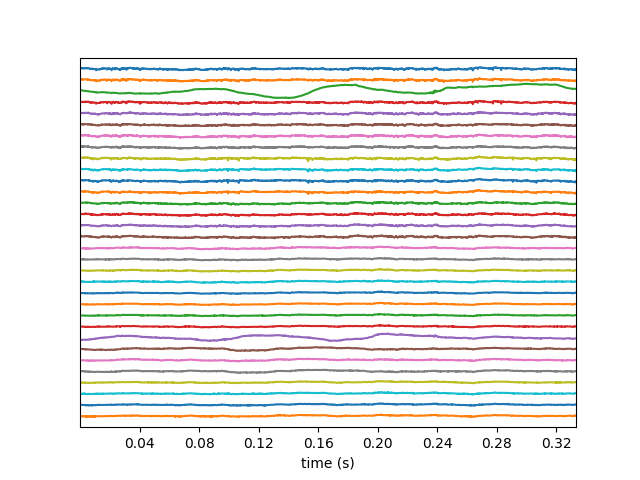

In [7]:
w_ts = sw.plot_timeseries(recording)

We can see that the spikes mainly appear separately on different tetrodes. Each tetrode belongs to a different `group`. We can load the `group` information in two ways:

- using the `set_channel_groups` in your RecordingExtractor (manually loading group information)
- loading a probe file using the `load_probe_file` from RecordingExtractor (automatically loading group information)

Let's use the second option. Probe files (`.prb`) also enable users to change the channel map (reorder the channels) and add channel grouping properties and locations. In this case, our probe file will order the channels in reverse and split them in 4 groups, representing the 4 tetrodes. We'll also add locations to separate the different tetrodes.

In [8]:
# only works on linux and mac. For windows, open the file using a text editor
!cat tetrode_32.prb

channel_groups = {
    # Tetrode index
    0:
        {
        'channels': [0, 1, 2, 3],
	'geometry': [[0,0], [1,0], [2,0], [3,0]],
        },
    1:
      	{
      	'channels': [4, 5, 6, 7],
	'geometry': [[6,0], [7,0], [8,0], [9,0]],
      	},
    2:
      	{
      	'channels': [8, 9, 10, 11],
	'geometry': [[12,0], [13,0], [14,0], [15,0]],
      	},
    3:
      	{
     	 'channels': [12, 13, 14, 15],
	 'geometry': [[18,0], [19,0], [20,0], [21,0]],
     	 },
    4:
	{
        'channels': [16, 17, 18, 19],
	'geometry': [[30,0], [31,0], [32,0], [33,0]],
        },
    5:
      	{
      	'channels': [20, 21, 22, 23],
	'geometry': [[36,0], [37,0], [38,0], [39,0]],
      	},
    6:
      	{
      	'channels': [24, 25, 26, 27],
	'geometry': [[42,0], [43,0], [44,0], [45,0]],
      	},
    7:
      	{
      	'channels': [28, 29, 30, 31],
	'geometry': [[48,0], [49,0], [50,0], [51,0]],
      	}
    }


In [9]:
recording_prb = recording.load_probe_file('tetrode_32.prb')

In [10]:
print('Original channels:', recording.get_channel_ids())
print('Channels after loading the probe file:', recording_prb.get_channel_ids())
print('Channel groups after loading the probe file:', recording_prb.get_channel_groups())

Original channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Channels after loading the probe file: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Channel groups after loading the probe file: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7]


<IPython.core.display.Javascript object>


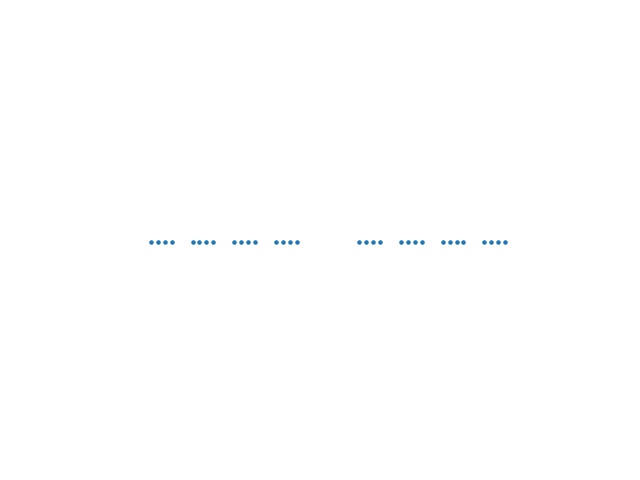

In [11]:
w_elec = sw.plot_electrode_geometry(recording_prb, markersize=5)

### Properties (and features)

For now we have seen that the `RecordingEctractor` can have `group` and `location` *properies*. These are very special properties that can be very important for spike sorting. Anything related to a channel can be saved as a property.

Similarly, for `SortingExtractor` objects, anything related to a unit can be stored as a property. In addition, for `SortingExtractor` objects we can also store anything related to spikes as *features* (e.g. waveforms, as we'll se later).

We can check which properties are in the estractor as follows:

In [12]:
print(recording.get_shared_channel_property_names())
print(recording_prb.get_shared_channel_property_names())

['group']
['group', 'location']


Let's add a new property! The first 16 channels are in the left hemisphere, the second 16 are in the right one:

In [13]:
for ch in recording_prb.get_channel_ids():
    if ch < 16:
        recording_prb.set_channel_property(ch, property_name='hemisphere', value='left')
    else:
        recording_prb.set_channel_property(ch, property_name='hemisphere', value='right')

In [14]:
print(recording_prb.get_shared_channel_property_names())

['group', 'hemisphere', 'location']


## Preprocessing recordings


Now that the probe information is loaded we can do some preprocessing using `spiketoolkit`.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings, remove a noisy channel, and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

Below, we bandpass filter the recording, remove channel 5, and apply common median reference to the original recording.

<IPython.core.display.Javascript object>


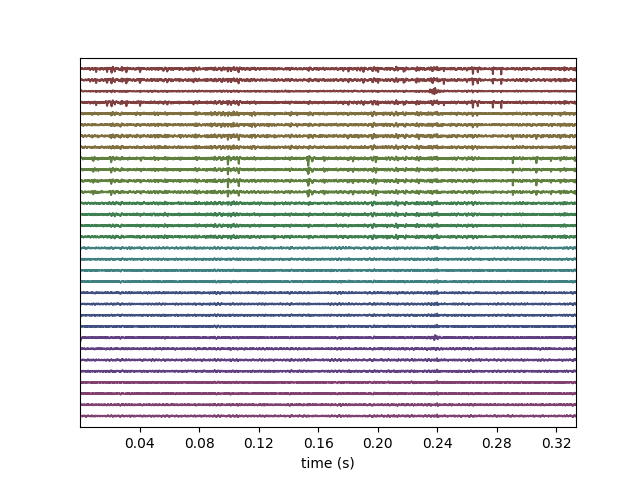

In [15]:
recording_f = st.preprocessing.bandpass_filter(recording_prb, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(recording_f, color_groups=True)

We can see that the first drive is quite active, while the second one is not. For sake of time, we can just focus on the first drive (channels 0-15). We can easily select these channels and get a new extractor using the `SubRecordingExtractor`:

In [16]:
recording_1 = se.SubRecordingExtractor(recording_f, channel_ids=range(16))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


<IPython.core.display.Javascript object>


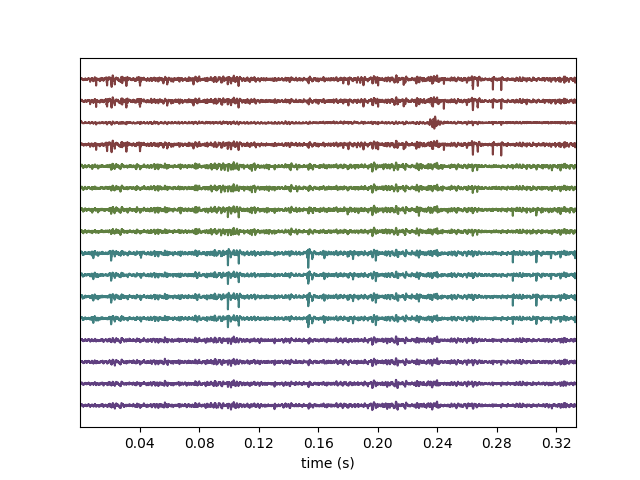

In [17]:
print(recording_1.get_channel_ids())
print(recording_1.get_channel_groups())
w = sw.plot_timeseries(recording_1, color_groups=True)

As we can notice from the first and second plot, channel 2 seems to be a bit noisy. We can remove it using the `remove_bad_channels` function:

In [18]:
recording_rm_noise = st.preprocessing.remove_bad_channels(recording_1, bad_channel_ids=[2])
print(recording_rm_noise.get_channel_ids())

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [19]:
recording_cmr = st.preprocessing.common_reference(recording_rm_noise, reference='median')

We can plot the traces after removing the bad channel and applying CMR:

<IPython.core.display.Javascript object>


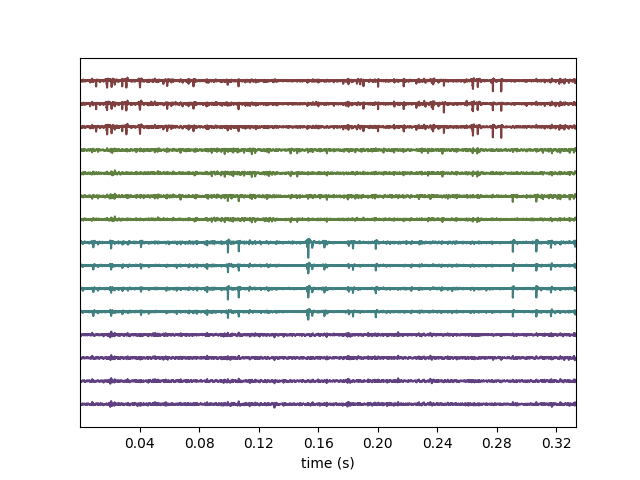

In [20]:
w = sw.plot_timeseries(recording_cmr, color_groups=True)

In [21]:
print('Channel ids for CMR recordings:', recording_cmr.get_channel_ids())
print('Channel groups for CMR recordings:', recording_cmr.get_channel_groups())

Channel ids for CMR recordings: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups for CMR recordings: [0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


Since we are going to spike sort the data, let's first cut out a 2-minute recording, to speed up computations.

In [22]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = se.SubRecordingExtractor(recording_cmr, start_frame=200*fs, end_frame=320*fs)

## Caching 

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **cache** it to a file and perform those operations (eg. filters, CMR, etc.) at once. This is particularly important if we are going to extract waveforms, templates, pca scores, or in general *post-process* the results.

In [23]:
recording_cache = se.CacheRecordingExtractor(recording_sub) 

The cached recording has all the previously loaded information:

In [24]:
print(recording_cache.get_channel_ids())
print(recording_cache.get_channel_groups())
print(recording_cache.get_num_frames() / recording_cache.get_sampling_frequency())

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
120.0


Under the hood, this convenient function is retrieving all the traces (in chunks, to save up some memory), applying the preprocessing steps, and dumping them to a binary temporary file:

In [25]:
recording_cache.filename

'/var/folders/vl/0vmqjsjn0dg8ycnxdx_mqrdw0000gr/T/tmpy3rzaw3v/tmp3anfkm26.dat'

Note that all extractors (including sorting extractors), have a temporary folder associated with it, that enables SpikeInterface to cache several data (including waveforms) and be gentle on RAM usage:

In [26]:
recording_cache.get_tmp_folder()

PosixPath('/var/folders/vl/0vmqjsjn0dg8ycnxdx_mqrdw0000gr/T/tmpy3rzaw3v')

The temporary files in the tmp folder, are *temporary*, and they will be deleted when the Python session is closed (or the object destroyed). To prevent this, we can simply move the binary file to a custom location:

In [27]:
recording_cache.move_to('filtered_data.dat') 
print(recording_cache.filename)

filtered_data.dat


Alternatively, we could have passed the `save_path` argument to the `se.CacheRecordingExtractor` directly.

## Dumping

If we now closed the Python session, we would have a nice `.dat` file, but no information on how to open it! 
In order to save the state of an extractor, we can use the **dumping** mechanism.
Each extractor can be converted to a dictionary, which holds the path to the data file and all relevant information:

In [28]:
recording_cache.dump_to_dict()

{'class': 'spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor',
 'module': 'spikeextractors',
 'kwargs': {'file_path': '/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/filtered_data.dat',
  'sampling_frequency': 30000.0,
  'numchan': 15,
  'dtype': 'float64',
  'recording_channels': [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'time_axis': 0,
  'geom': None,
  'offset': 0,
  'gain': None,
  'is_filtered': True},
 'key_properties': {'group': array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
  'location': array([[ 0.00000000e+000,  0.00000000e+000,  1.77863633e-322],
         [ 1.00000000e+000,  0.00000000e+000,  1.52973828e-308],
         [ 3.00000000e+000,  0.00000000e+000,  0.00000000e+000],
         [ 6.00000000e+000,  0.00000000e+000,  0.00000000e+000],
         [ 7.00000000e+000,  0.00000000e+000,  1.48219694e-322],
         [ 8.00000000e+000,  0.00000000

We can now dump our extractor object, so it can be loaded in a future session. We can dump either to `.json` or to `.pkl`. Dumping to pickle also allow us to store properties (other than group and locations) and features (for `SortingExtractor` objects).

In [29]:
recording_cache.dump_to_pickle('recording.pkl')

In another session, we can pick up from where we left by loading the extractor from the pickle file:

In [30]:
recording_loaded = se.load_extractor_from_pickle('recording.pkl')

<IPython.core.display.Javascript object>


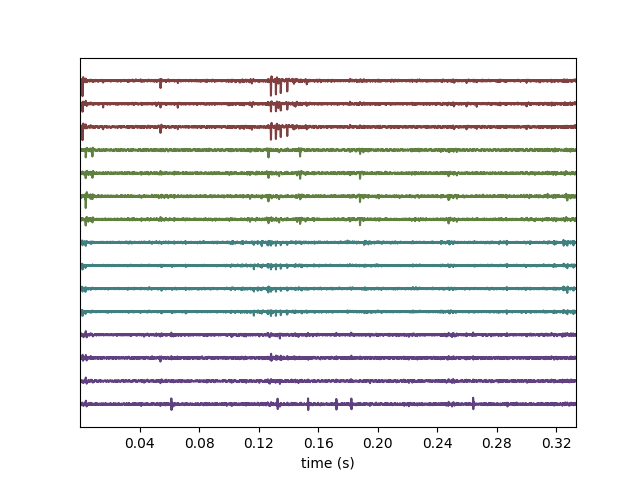

In [31]:
w = sw.plot_timeseries(recording_loaded, color_groups=True)

**IMPORTANT**: the same caching/dumping mechanisms are available also for all SortingExtractor

# Spike sorting

We can now run spike sorting on the above recording. We will use `klusta` and `ironclust` for this demonstration, to show how easy SpikeInterface makes it to interchengably run different sorters :)

Let's first check the installed sorters in spiketoolkit to see if klusta is available. Then we can check the `klusta` default parameters.
We will sort the bandpass cached filtered recording the `recording_cache` object.

In [32]:
ss.installed_sorter_list

[spikesorters.hdsort.hdsort.HDSortSorter,
 spikesorters.klusta.klusta.KlustaSorter,
 spikesorters.ironclust.ironclust.IronClustSorter]

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `spikesorters` module:

In [33]:
ss.get_default_params('klusta')

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50}

In [35]:
ss.run_sorter?

In [36]:
ss.run_klusta?

We will set the `adjacency_radius` to 50 microns as electrodes belonging to the same tetrode are within this distance.

In [34]:
# run spike sorting on entire recording
sorting_KL_all = ss.run_klusta(recording_cache, output_folder='results_all_klusta', adjacency_radius=50)
print('Found', len(sorting_KL_all.get_unit_ids()), 'units')

WARNING! The recording contains several group. In order to spike sort by 'group' use grouping_property='group' as argument.
RUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/results_all_klusta/run_klusta.sh
Found 40 units


### Spike sorting by group

Since we have 4 tetrodes and we know that they are physically apart, we would like to sort them separately.

Here is how it's done in SpikeInterface:

![](sort_by_group.png)

In [35]:
# run spike sorting by group (add picture)
sorting_KL = ss.run_klusta(recording_cache, adjacency_radius=50, 
                                      output_folder='results_split_klusta', 
                                      grouping_property='group', parallel=True)
print('Found', len(sorting_KL.get_unit_ids()), 'units')

RUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/results_split_klusta/0/run_klusta.shRUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/results_split_klusta/2/run_klusta.sh

RUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/results_split_klusta/3/run_klusta.sh
RUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/results_split_klusta/1/run_klusta.sh
Found 53 units


In [36]:
print(type(sorting_KL))

<class 'spikeextractors.multisortingextractor.MultiSortingExtractor'>


In [37]:
sorting_KL.sortings

### Installing IronClust (requires MATLAB)

For MATLAB-based sorters, all you need to do is cloning the sorter repo and point it to SpikeInterface:

Let's clone ironclust in the current directory:

In [ ]:
!git clone https://github.com/jamesjun/ironclust

Now all we have to tell the IronClustSorter class where is the ironclust repo:

In [38]:
ss.IronClustSorter.set_ironclust_path('./ironclust')

Setting IRONCLUST_PATH environment variable for subprocess calls to: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/ironclust


Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [39]:
ss.IronClustSorter.ironclust_path

'/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/ironclust'

In [40]:
ss.installed_sorter_list

[spikesorters.hdsort.hdsort.HDSortSorter,
 spikesorters.klusta.klusta.KlustaSorter,
 spikesorters.ironclust.ironclust.IronClustSorter]

In [41]:
# run spike sorting by group
sorting_IC = ss.run_ironclust(recording_cache, 
                              output_folder='results_split_ic', 
                              grouping_property='group', parallel=True)
print('Found', len(sorting_IC.get_unit_ids()), 'units')

Warning! The recording is already filtered, but Ironclust filter is enabled. You can disable filters by setting 'filter' parameter to False
Warning! The recording is already filtered, but Ironclust filter is enabled. You can disable filters by setting 'filter' parameter to False
Warning! The recording is already filtered, but Ironclust filter is enabled. You can disable filters by setting 'filter' parameter to False
Warning! The recording is already filtered, but Ironclust filter is enabled. You can disable filters by setting 'filter' parameter to False
RUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/results_split_ic/0/run_ironclust.sh
RUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/results_split_ic/2/run_ironclust.sh
RUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NW

The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [42]:
print('Units', sorting_KL.get_unit_ids())

Units [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


In [43]:
print('Units', sorting_KL.get_unit_spike_train(13))

Units [    465    1972    4343 ... 3598975 3599393 3599510]


We can use `spikewidgets` functions to quickly visualize some unit features:

<IPython.core.display.Javascript object>


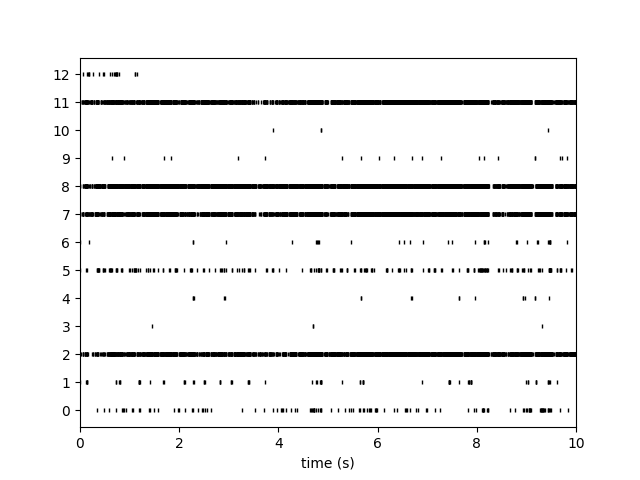

In [48]:
w_rs = sw.plot_rasters(sorting_IC, trange=[0,10])

We can now perform some automatic curation by thresholding low snr units on the split sorting result

## Postptocessing

The `postprocessing` submodule of `spiketoolkit` allow us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can also compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons.

To extract the waveforms, we can run:

In [45]:
waveforms = st.postprocessing.get_unit_waveforms(recording_cache, sorting_IC, verbose=True)

Waveform 1/13
Waveform 2/13
Waveform 3/13
Waveform 4/13
Waveform 5/13
Waveform 6/13
Waveform 7/13
Waveform 8/13
Waveform 9/13
Waveform 10/13
Waveform 11/13
Waveform 12/13
Waveform 13/13


In [46]:
waveforms[0].shape

(300, 15, 180)

Similarly, we can get templates, maximum channels, and pca scores. 
Whem these are computed, they are automatically stored in the `SortingExtractor` object, so that they don't need to be recomputed. 

Each waveform is associated with a specific spike, so they are saved as spike *features*:


In [51]:
sorting_IC.get_shared_unit_spike_feature_names()

['waveforms', 'waveforms_idxs']

You may have noticed that 300 waveforms were extracted from the spike train of the first unit. However, it has more spikes:

In [52]:
len(sorting_IC.get_unit_spike_train(0))

1562

It can be convenient to only compute a subset of waveforms to speed up the calculation. The `waveform_idxs` property contains the spike indexes associated with the waveforms.

In [53]:
print(sorting_IC.get_unit_spike_features(0, 'waveforms_idxs'))

[   1    2    4    5    9   14   17   18   19   22   27   31   34   45
   52   53   54   66   80   82   85   89   96  107  108  113  122  133
  141  142  148  152  159  161  170  171  175  178  182  187  191  192
  202  204  211  219  223  227  229  233  249  253  254  259  260  268
  271  278  298  299  303  308  310  315  317  319  326  333  342  347
  353  354  360  361  364  376  379  381  393  399  402  408  412  414
  422  425  427  432  436  438  446  458  459  461  467  475  481  482
  483  489  491  494  501  506  511  512  520  529  530  538  542  558
  565  567  569  572  574  579  580  583  587  593  597  609  618  620
  621  632  638  642  644  651  654  666  667  672  682  685  686  688
  703  704  712  713  733  740  746  752  760  762  768  787  792  796
  799  801  826  831  853  874  877  878  879  883  897  898  906  916
  918  921  923  927  933  937  944  948  957  961  963  979  980  984
  986  988  989  993  997 1017 1023 1024 1026 1030 1031 1042 1059 1078
 1079 

Since waveforms are already computed, the next time we (or another function - e.g. `get_unit_templates()`) call it it will just return the stored waveforms.

In [54]:
waveforms = st.postprocessing.get_unit_waveforms(recording_cache, sorting_IC, verbose=True)

Lighthing fast! 

If we want to recompute the waveforms, for example because we want to extract the waveforms divided by group, we can use the `recompute_info` argument (available for all `postprocessing`, `validation`, and `curation` functions):

In [56]:
waveforms_group = st.postprocessing.get_unit_waveforms(recording_cache, sorting_IC, 
                                                       grouping_property='group', recompute_info=True,
                                                       verbose=True)

Waveform 1/13
Waveform 2/13
Waveform 3/13
Waveform 4/13
Waveform 5/13
Waveform 6/13
Waveform 7/13
Waveform 8/13
Waveform 9/13
Waveform 10/13
Waveform 11/13
Waveform 12/13
Waveform 13/13


In [57]:
sorting_IC.get_shared_unit_property_names()

['group', 'mda_max_channel', 'waveforms_channel_idxs']

In [58]:
for wf in waveforms_group:
    print(wf.shape)

(300, 3, 180)
(300, 3, 180)
(300, 3, 180)
(197, 3, 180)
(280, 3, 180)
(300, 4, 180)
(300, 4, 180)
(300, 4, 180)
(300, 4, 180)
(165, 4, 180)
(96, 4, 180)
(300, 4, 180)
(153, 4, 180)


<IPython.core.display.Javascript object>


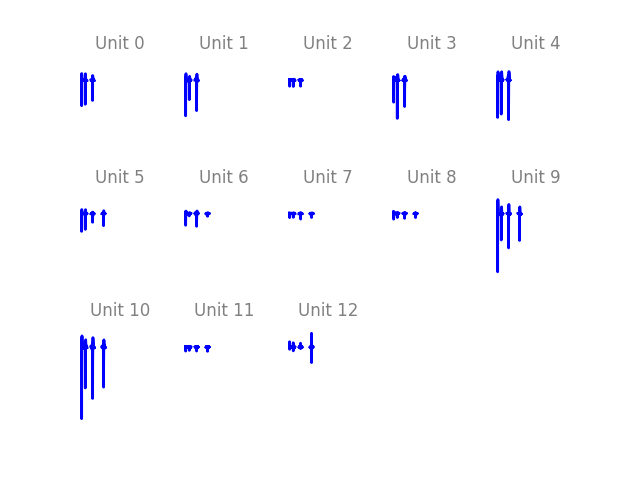

In [59]:
w_wf = sw.plot_unit_templates(sorting=sorting_IC, recording=recording_cache)

In [60]:
st.postprocessing.get_template_features_list()

['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

In [61]:
features = st.postprocessing.compute_unit_template_features(recording_cache, sorting_IC, as_dataframe=True, 
                                                            upsampling_factor=10)
display(features)

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,[0.00018],[0.00013333333333333334],[-0.26655080830160616],[1535489.4481028742],[-44613.52067036162]
1,[0.0005833333333333334],[0.00016666666666666666],[-0.1707498238307778],[1005426.5334982472],[-42349.86299673285]
2,[0.0008433333333333333],[0.00014],[-0.1248125533350684],[155259.7549787713],[-6061.748177585193]
3,[0.0008033333333333333],[0.00015999999999999999],[-0.1509214770176736],[532358.0058114699],[-36700.393260383455]
4,[0.0006833333333333333],[0.00018666666666666666],[-0.21733832749691465],[775335.0479803714],[-60638.31030857169]
5,[0.00027333333333333333],[0.00017],[-0.22108801338014464],[697906.1914395293],[-29371.538641797]
6,[0.0008433333333333333],[0.00024333333333333333],[-0.2266210498073671],[136070.72758993268],[-14198.090762777587]
7,[0.0009333333333333333],[0.00011],[-0.08627500590671254],[304131.69796509936],[-2719.9661037825654]
8,[0.00085],[0.00011],[-0.06820570536962489],[316848.7219821279],[-127.81084791339269]
9,[0.00051],[0.00011666666666666667],[-0.2565225724137621],[939526.1740488653],[-118752.18343323504]


For more information about these waveform features, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

## Validation

The `spiketoolkit` package also provides several functions to compute qualitity metrics about the spike sorting results through the `validation` module.

Let's see what metrics are available:



In [62]:
st.validation.get_quality_metrics_list()

['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'nn_hit_rate',
 'nn_miss_rate']

We can either compute one metric at a time, or compute a subset of metrics using the `compute_quality_metrics` function:

In [63]:
duration = recording.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting_IC, duration_in_frames=duration)
print('ISI violations:', isi_violations)

snrs = st.validation.compute_snrs(sorting_IC, recording_cache)
print('SNRs:', snrs)

ISI violations: [ 0.16411173  2.36982916  2.22601127  0.          0.          0.23148107
  8.53488773  2.50600248  2.26652624  0.          0.          2.34051632
 25.65724793]
SNRs: [20.80881498 28.78877193  4.41369607 30.75352102 33.14381783 14.37758412
  9.05471213  4.49581853  4.18362654 48.35423599 53.44739608  3.728155
 13.53295158]


In [64]:
quality_metrics = st.validation.compute_quality_metrics(sorting_IC, recording_cache, 
                                                        metric_names=['isi_violation', 'snr'], as_dataframe=True)
display(quality_metrics)

,isi_violation,snr
0,0.033157,20.808815
1,0.478804,28.788772
2,0.449747,4.413696
3,0.000000,30.753521
4,0.000000,33.143818
5,0.046769,14.377584
6,1.724402,9.054712
7,0.506317,4.495819
8,0.457933,4.183627
9,0.000000,48.354236


For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Curation

### 1) Manual curation using Phy

To perform manual curation we will export the data to Phy. 

In [65]:
st.postprocessing.export_to_phy(recording_cache, 
                                sorting_IC, output_folder='phy_IC',
                                grouping_property='group', verbose=True, recompute_info=True)

Waveform 1/13
Waveform 2/13
Waveform 3/13
Waveform 4/13
Waveform 5/13
Waveform 6/13
Waveform 7/13
Waveform 8/13
Waveform 9/13
Waveform 10/13
Waveform 11/13
Waveform 12/13
Waveform 13/13
Fitting PCA of 3 dimensions on 10000 waveforms
Projecting waveforms on PC
Saved phy format to:  /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/phy_IC
Run:

phy template-gui  /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/phy_IC/params.py


In [66]:
%%capture --no-display
!phy template-gui phy_IC/params.py

After curating the results we can reload it using the `PhySortingExtractor`:

In [67]:
sorting_IC_phy_curated = se.PhySortingExtractor('phy_IC/', exclude_cluster_groups=['noise'])

In [68]:
print(len(sorting_IC_phy_curated.get_unit_ids()))

13


In [69]:
st.postprocessing.export_to_phy(recording_cache, 
                                sorting_KL, output_folder='phy_KL',
                                grouping_property='group', verbose=True, recompute_info=True)

Waveform 1/53
Waveform 2/53
Waveform 3/53
Waveform 4/53
Waveform 5/53
Waveform 6/53
Waveform 7/53
Waveform 8/53
Waveform 9/53
Waveform 10/53
Waveform 11/53
Waveform 12/53
Waveform 13/53
Waveform 14/53
Waveform 15/53
Waveform 16/53
Waveform 17/53
Waveform 18/53
Waveform 19/53
Waveform 20/53
Waveform 21/53
Waveform 22/53
Waveform 23/53
Waveform 24/53
Waveform 25/53
Waveform 26/53
Waveform 27/53
Waveform 28/53
Waveform 29/53
Waveform 30/53
Waveform 31/53
Waveform 32/53
Waveform 33/53
Waveform 34/53
Waveform 35/53
Waveform 36/53
Waveform 37/53
Waveform 38/53
Waveform 39/53
Waveform 40/53
Waveform 41/53
Waveform 42/53
Waveform 43/53
Waveform 44/53
Waveform 45/53
Waveform 46/53
Waveform 47/53
Waveform 48/53
Waveform 49/53
Waveform 50/53
Waveform 51/53
Waveform 52/53
Waveform 53/53
Fitting PCA of 3 dimensions on 10000 waveforms
Projecting waveforms on PC
Saved phy format to:  /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/phy_KL

In [ ]:
%%capture --no-display
!phy template-gui phy_KL/params.py

### 2) Automatic curation based on quality metrics

In [70]:
snr_thresh = 5
isi_viol_thresh = 0.5

In [71]:
sorting_auto = st.curation.threshold_isi_violations(sorting_KL, isi_viol_thresh, 'greater', duration)

In [72]:
len(sorting_auto.get_unit_ids())

9

In [73]:
sorting_auto = st.curation.threshold_snrs(sorting_auto, recording_cache, snr_thresh, 'less')

In [74]:
len(sorting_auto.get_unit_ids())

9

### 3) Consensus-based curation 

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

In [75]:
mcmp = sc.compare_multiple_sorters([sorting_KL, sorting_IC], ['KL', 'IC'])

<IPython.core.display.Javascript object>


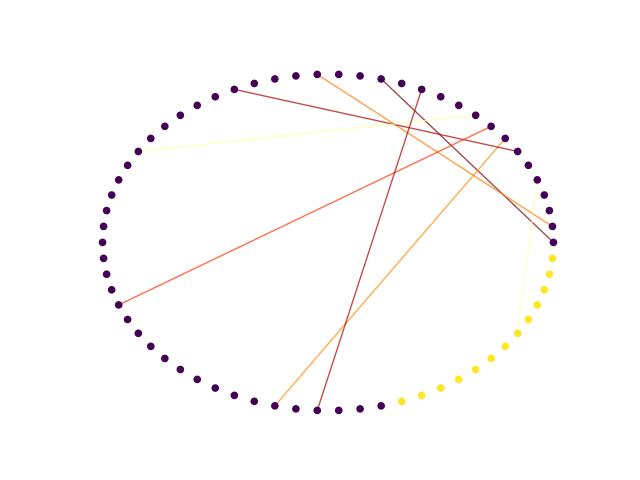

<IPython.core.display.Javascript object>


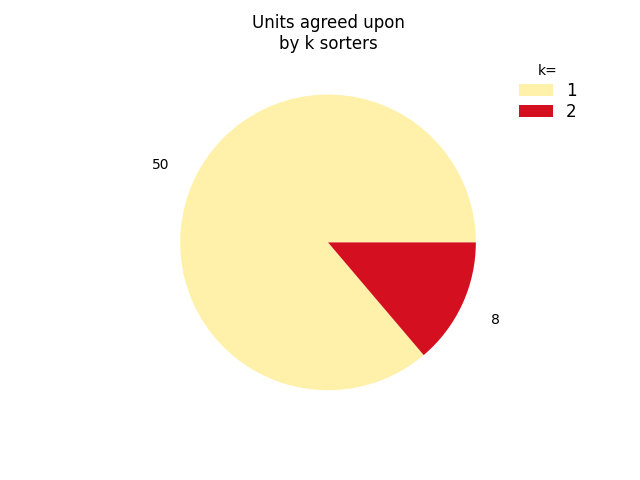

<IPython.core.display.Javascript object>


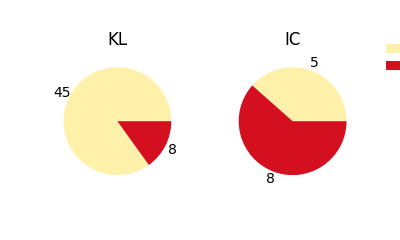

In [76]:
w = sw.plot_multicomp_graph(mcmp)
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [77]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [78]:
agreement_sorting.get_unit_ids()

[1, 4, 12, 16, 21, 30, 41, 51]

In [79]:
st.postprocessing.export_to_phy(recording_cache, 
                                agreement_sorting, output_folder='phy_AGR',
                                grouping_property='group', verbose=True, recompute_info=True)

Waveform 1/8
Waveform 2/8
Waveform 3/8
Waveform 4/8
Waveform 5/8
Waveform 6/8
Waveform 7/8
Waveform 8/8
Fitting PCA of 3 dimensions on 10000 waveforms
Projecting waveforms on PC
Saved phy format to:  /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/phy_AGR
Run:

phy template-gui  /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/phy_AGR/params.py


In [80]:
%%capture --no-display
!phy template-gui phy_AGR/params.py

## Save to / load from NWB

In [ ]:
se.NwbRecordingExtractor.write_recording(recording_cache, 'si_tutorial.nwb')

In [ ]:
se.NwbSortingExtractor.write_sorting(sorting_IC, 'si_tutorial.nwb')

In [ ]:
recording_nwb = se.NwbRecordingExtractor('si_tutorial.nwb')
sorting_nwb = se.SortingExtractor('si_tutorial.nwb')